In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

Load the data

In [75]:
train_valid_df= pd.read_csv("mnist_train.csv")
test_df = pd.read_csv("mnist_test.csv")


#### Preprocess the data

Separate features (X) and labels (y) and  Normalize pixel values to [0, 1] or efficient training by scaling pixel values to a manageable range.

In [76]:
X_train_valid=train_valid_df.iloc[:,1:].values/255.0
y_train_valid=train_valid_df.iloc[:,0].values

In [77]:
X_test=test_df.iloc[:,1:].values/255.0
y_test=test_df.iloc[:,0].values

Split train_valid_df into training (80%) and validation (20%) sets


The stratify parameter in the train_test_split function ensures that the class distribution (proportions of labels) in the split datasets is the same as in the original dataset.

In [78]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, stratify=y_train_valid, random_state=42)

#### Utilize the Torch data loader to efficiently load and manage the dataset

Convert to PyTorch tensors

In [79]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

Create PyTorch datasets

In [80]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

 Create DataLoaders

In [81]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

####  Implementing feedforward neural network

In [82]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim_1,hidden_dim_2, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        # Non-linearity 1
        self.relu1 = nn.ReLU()

        # Linear function 2
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Non-linearity 2
        self.relu2 = nn.ReLU()

        # Linear function 3 (readout)
        self.fc3 = nn.Linear(hidden_dim_2, output_dim)



    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)

        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.relu2(out)

        # Linear function 3 (readout)
        out = self.fc3(out)
        return out

This function trains and evaluates a model for a specified number of epochs, tracking and returning the training and validation losses and accuracies at each epoch.

In [83]:
def train_loop(model, train_loader, valid_loader, criterion, optimizer, epochs):

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(epochs):
        model.train()
        training_loss = 0
        correct_train = 0
        total_train=0


        for X_batch, y_batch in train_loader:

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            training_loss += loss.item()
            loss.backward()
            optimizer.step()

            _, predicted_classes = torch.max(y_pred, 1)
            correct_train += (predicted_classes == y_batch).sum().item()
            total_train += y_batch.size(0)

        train_losses.append(training_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation step
        model.eval()
        valid_loss = 0
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:

                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                valid_loss += loss.item()
                _, predicted_classes = torch.max(y_pred, 1)
                correct_valid += (predicted_classes == y_batch).sum().item()
                total_valid+= y_batch.size(0)

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(correct_valid / total_valid)

        # # Optional: print progress every 10 epochs
        # if (epoch + 1) % 10 == 0:
        #     print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}')
        #     print(f'Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}')

    return train_losses, valid_losses, train_accuracies, valid_accuracies


Model parameters

In [84]:
input_dim = 28*28
hidden_dim_1 = 128 # not sure which number to choose but the default is 128 or 256
hidden_dim_2 = 64
output_dim = 10

Initialize model

In [85]:
model = FeedforwardNeuralNetModel(input_dim, hidden_dim_1,hidden_dim_2, output_dim)

In [86]:
print(model)

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


Loss function: Cross Entropy Loss

In [87]:
criterion = nn.CrossEntropyLoss()

Optimizer: Stochastic Gradient Descent (SGD)

In [88]:
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [89]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


Train the model

In [90]:
epochs = 10

In [91]:
train_loss, train_accuracy, valid_loss, valid_accuracy = train_loop(
    model, train_loader, valid_loader, criterion, optimizer, epochs)

ploting the training and validation losses over epochs

ploting the training and validation accuracies over epochs

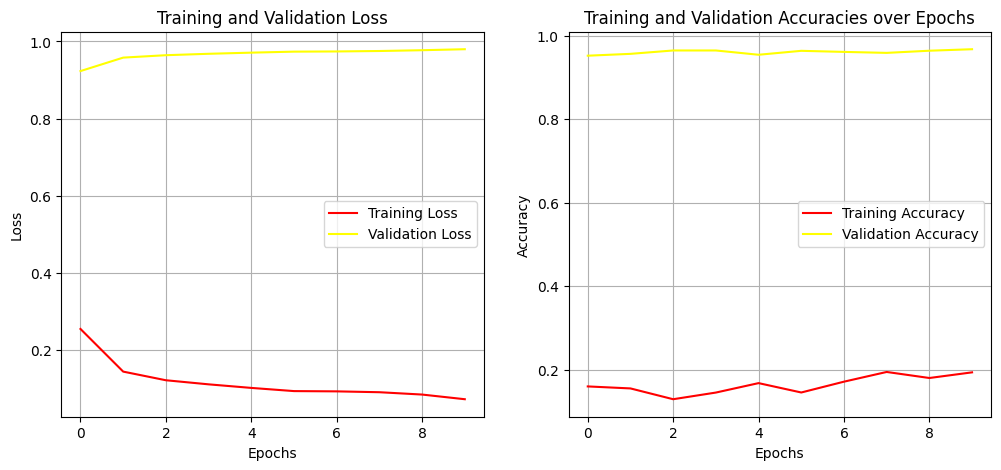

In [92]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss, label='Training Loss', color='red')
plt.plot(range(epochs), valid_loss, label='Validation Loss', color='yellow')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracy, label='Training Accuracy', color='red')
plt.plot(range(epochs), valid_accuracy, label='Validation Accuracy', color='yellow')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies over Epochs')
plt.legend()
plt.grid(True)
plt.show()


evaluating the training model on the test dataset, calculating and printing the test accuracy.

In [93]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        _, predicted_classes = torch.max(y_pred, 1)
        correct += (predicted_classes == y_batch).sum().item()
        total += y_batch.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 96.66%


 defining a feedforward neural network model with variable layer dimensions, using ReLU activations between layers except for the output layer.

In [94]:
class FeedforwardNeuralNetModelloop(nn.Module):
    def __init__(self, dims):
        super(FeedforwardNeuralNetModelloop, self).__init__()
        layers = []
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:
                layers.append(nn.ReLU())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


 performing hyperparameter tuning by training the model with different parameter combinations and tracking the best set of hyperparameters based on the highest validation accuracy.





In [95]:
learning_rates = [0.001, 0.01, 0.1, 0.0001]
batch_sizes = [16, 32, 64, 128]
hidden_dims = [
    [784, 128, 64, 32],
    [784, 256, 128, 64],
    [784, 512, 256, 128],
    [784, 64, 32, 16],

    [784, 128, 32],
    [784, 128, 256, 64, 10],
    [784, 256, 512, 128, 64, 10],
    [784, 256, 128, 512, 128, 64, 10]
]

# Initialize the best accuracy for comparison
best_accuracy = 0
best_params = {}
best_train_losses, best_valid_losses = [], []
best_train_accuracies, best_valid_accuracies = [], []

Iterate over the combinations of learning rate, batch size, and hidden dimensions

In [96]:
for lr in learning_rates:
    for batch_size in batch_sizes:
        for dims in hidden_dims:

            model = FeedforwardNeuralNetModelloop(dims)
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


            train_losses, valid_losses, train_accuracies, valid_accuracies = train_loop(
                model, train_loader, valid_loader, criterion, optimizer, epochs=10)



            if valid_accuracies[-1] > best_accuracy:
                best_accuracy = valid_accuracies[-1]
                best_params = {'learning_rate': lr, 'batch_size': batch_size, 'hidden_dims': dims}

                # Save the best model
                torch.save(model.state_dict(), "best_model.pth")
                best_train_losses, best_valid_losses = train_losses, valid_losses
                best_train_accuracies, best_valid_accuracies = train_accuracies, valid_accuracies





 Output the best hyperparameters and validation accuracy

In [97]:
print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy}")

Best Hyperparameters: {'learning_rate': 0.1, 'batch_size': 32, 'hidden_dims': [784, 512, 256, 128]}
Best Validation Accuracy: 0.9806666666666667


plot the best model's performance

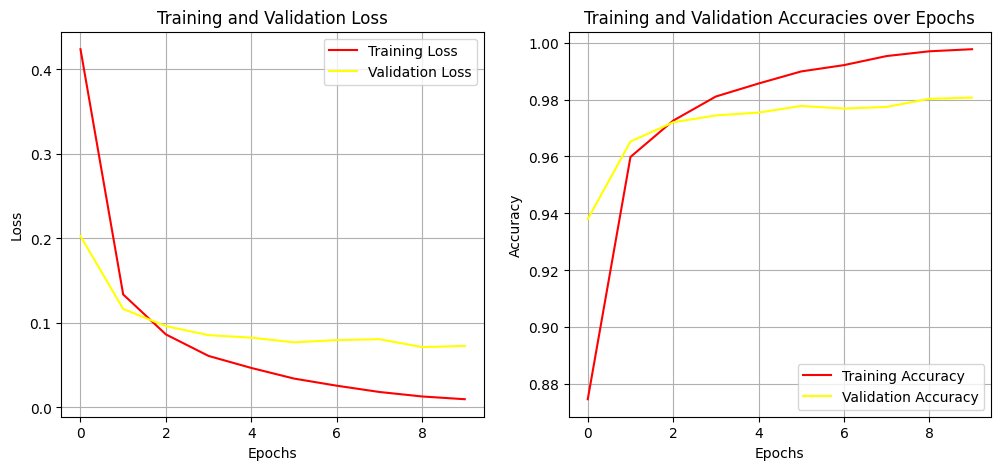

In [98]:
plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(10), best_train_losses, label='Training Loss', color='red')
plt.plot(range(10), best_valid_losses, label='Validation Loss', color='yellow')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(10), best_train_accuracies, label='Training Accuracy', color='red')
plt.plot(range(10), best_valid_accuracies, label='Validation Accuracy', color='yellow')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies over Epochs')
plt.legend()
plt.grid(True)

plt.show()

In [101]:
# Assuming test_dataset is already created and preprocessed
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)
best_model = FeedforwardNeuralNetModelloop(best_params['hidden_dims'])
# Load the state_dict from the saved file
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()  # Set the model to evaluation mode


<ipython-input-101-5c14bd823d2b>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_model.pth'))


FeedforwardNeuralNetModelloop(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [102]:
all_preds = []
all_labels = []

# Test loop
with torch.no_grad():
    for X_test, y_test in test_loader:

        outputs = best_model(X_test)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())


test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9816


In [103]:
cm = confusion_matrix(all_labels, all_preds)



 Display the confusion matrix

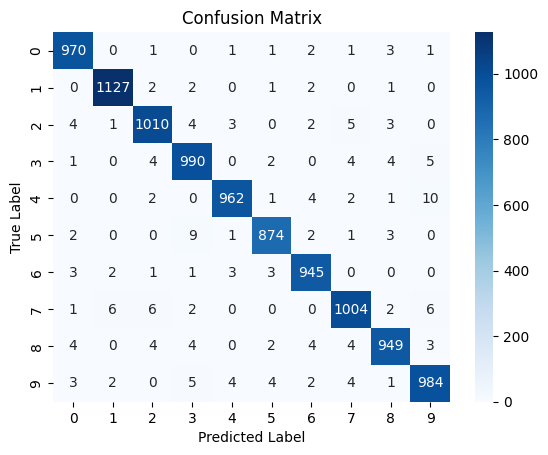

In [104]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

 defining a convolutional neural network (CNN) with dropout, layer normalization, and two convolutional layers followed by fully connected layers for classification.

In [105]:
class CNNWithDropoutAndLayerNorm(nn.Module):
     def __init__(self, in_channels=1, num_classes=10):
        super(CNNWithDropoutAndLayerNorm, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv1_norm = nn.LayerNorm([8,28,28])
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.dropout1 = nn.Dropout(p=0.25)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv2_norm = nn.LayerNorm([16,14,14])
        self.dropout2 = nn.Dropout(p=0.25)

        # self.fc1 = nn.Linear(16*7*7, num_classes)
        self.fc1 = nn.Linear(16*7*7, 128)
        self.fc1_norm = nn.LayerNorm(128)
        self.fc2 = nn.Linear(128, num_classes)

     def forward(self,x):
        x = F.relu(self.conv1(x))
        x=self.conv1_norm(x)
        x = self.pool(x)
        x=self.dropout1(x)

        x = F.relu(self.conv2(x))
        x=self.conv2_norm(x)
        x = self.pool(x)
        x=self.dropout2(x)

        x=x.view(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=self.fc1_norm(x)
        x=self.fc2(x)
        return x


reshaping the training, validation, and test datasets for a CNN, wraps them in TensorDataset objects, and creates corresponding DataLoader instances for batch processing.

In [106]:
X_train_tensor_cnn = X_train_tensor.view(-1, 1, 28, 28)
X_valid_tensor_cnn = X_valid_tensor.view(-1, 1, 28, 28)
X_test_tensor_cnn = X_test_tensor.view(-1, 1, 28, 28)

train_dataset_cnn = TensorDataset(X_train_tensor_cnn, y_train_tensor)
valid_dataset_cnn = TensorDataset(X_valid_tensor_cnn, y_valid_tensor)
test_dataset_cnn = TensorDataset(X_test_tensor_cnn, y_test_tensor)

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=64, shuffle=True)
valid_loader_cnn = DataLoader(valid_dataset_cnn, batch_size=64, shuffle=False)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=64, shuffle=False)

 initializing a CNN model with dropout and layer normalization, sets the loss function to cross-entropy, and uses the Adam optimizer with a learning rate of 0.001.

In [107]:
model_cnn = CNNWithDropoutAndLayerNorm(in_channels=1, num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

In [108]:
train_losses, valid_losses, train_accuracies, valid_accuracies = train_loop(
    model_cnn, train_loader_cnn, valid_loader_cnn, criterion, optimizer, epochs=20)

 creating plots of training and validation loss, and training and validation accuracy over epochs.

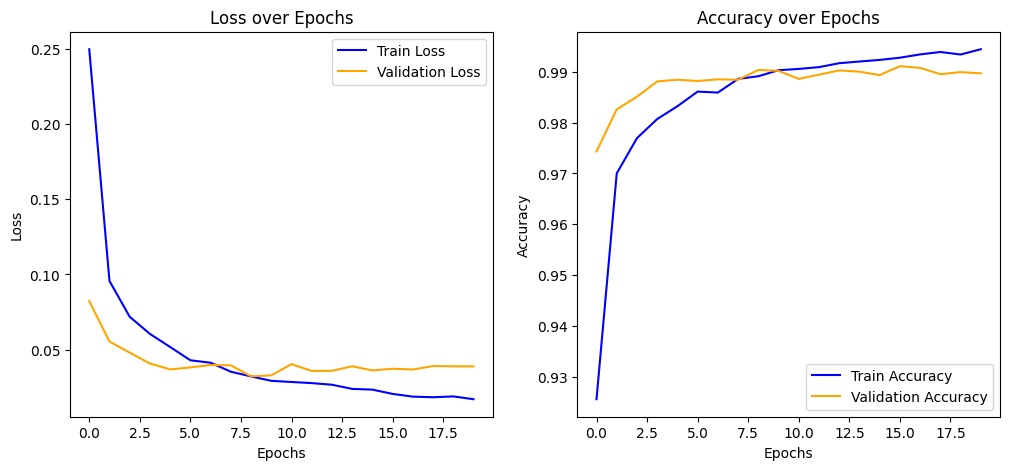

In [109]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Train Loss', color='blue')
plt.plot(range(len(valid_losses)), valid_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(len(valid_accuracies)), valid_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

evaluating the trained CNN model on the test set, calculating and printing the test accuracy.

In [110]:
model_cnn.eval()
# test_correct = 0
# test_total = 0

with torch.no_grad():
    test_correct = 0
    test_total = 0
    for X_batch, y_batch in test_loader_cnn:
        y_pred = model_cnn(X_batch)
        _, predicted_classes = torch.max(y_pred, 1)
        test_correct += (predicted_classes == y_batch).sum().item()
        test_total += y_batch.size(0)

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 99.14%
